In [1]:
#导入需要的工具库
import pickle
import numpy as np
import matplotlib.pyplot as pyplot
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops
import math
from matplotlib import pyplot as plt

# 数据

本次实验采用的数据来源于CIFAR-10 dataset，由50000条训练集和10000条测试集构成，分成5个训练集data_batch_1到data_batch_5和一个测试集test_batch。
- 用 pickle.load() 将所有文件中的数据都读入内存
- 每个 Pickle 文件都含有 10000 张图片及其展示的内容标签。Pickle 文件所包含的对象是一个词典，该词典有如下4个键：
  - data：图像像素数据，np.array 类型
  - labels：图像内容标签，list 类型
  - filenames：原始图像的文件名（目前用不上）
  - batch_label：数据所属的训练集编号（没什么用）
- data 是一个尺寸为 (10000, 3072) 的 Numpy 数组
- 每一行是一张图片的所有像素，长度为3072
- 每张图片的尺寸是32x32=1024，其三个颜色通道串联接在一起，即 1024,1024,1024
- 需要将每张尺寸为 (1, 3072) 的图片还原为正常的图像尺寸 (32, 32, 3)
- 由于考虑到目前第一维只能是颜色通道，因此应该先将其 reshape(3, 32, 32), 再用 transpose 把颜色通道交换至最后一个维度。
- labels 是一个长度为 10000 的 list，表示图像的实际内容类别，取值为 [0, 9]，其涵义如下：
    - 0 = airplane
    - 1 = automobile
    - 2 = bird
    - 3 = cat
    - 4 = deer
    - 5 = dog
    - 6 = frog
    - 7 = horse
    - 8 = ship
    - 9 = truck

In [3]:
#数据集由Pickle模块存放，也以此解压
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

CIFAR-10数据集的标签信息存放在batches.meta文件中，每一个序号代表的类别都从中解码得到。下面编写函数获取训练集、测试集以及类别对应信息。

In [4]:
#加载所有数据
def loadDataSet():
    train_set_x_orig=[]
    train_set_y=[]
    #添加训练数据
    for i in range(1,6):
        fileName='data_batch_%s'%(str(i))
        rawDataDic=unpickle(fileName)
        train_set_x_orig.extend(list(rawDataDic[b'data']))
        train_set_y.extend(rawDataDic[b'labels'])
    train_set_x_orig=np.array(train_set_x_orig)
    train_set_y=np.array(train_set_y)
    #添加元数据
    rawMetadata=unpickle('batches.meta')
    classes=rawMetadata[b'label_names']
    for i in range(len(classes)):
        classes[i]=classes[i].decode()
    #添加测试数据
    rawTestDataDic=unpickle('test_batch')
    test_set_x_orig=rawTestDataDic[b'data']
    test_set_y=np.array(rawTestDataDic[b'labels'])
    #输出时需要对部分数据进行转置处理
    return train_set_x_orig.T, train_set_y.T, test_set_x_orig.T, test_set_y.T, classes

In [5]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes=loadDataSet()

数据浏览：CIFAR-10数据集解压后以字典形式存储，其中b'data'对应于各图片RGB矩阵原始矩阵大小为(32x32x3)，图像像素大小32x32，b'label'对应于图片所指的类别。除此之外解压后的图片信息已经完成了flatten，从RGB图片被规则化成一串矢量，挑选其中一张图片将其还原。

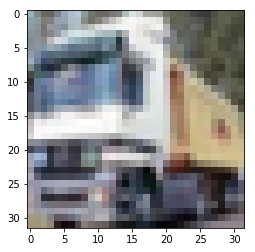

y=9 ,it is a truck


In [6]:
#还原图片
def showpic(data):
    arr = data.reshape(3, 32, 32)
    # 得到RGB通道
    r = Image.fromarray(arr[0]).convert('L')
    g = Image.fromarray(arr[1]).convert('L')
    b = Image.fromarray(arr[2]).convert('L')
    image = Image.merge("RGB", (r, g, b))
    # 显示图片
    pyplot.imshow(image)
    pyplot.show()
#显示第2张照片
showpic(train_set_x_orig[:,1])
print('y=%s ,it is a %s'%(train_set_y[1],classes[train_set_y[1]]))

由于图像原始RGB文件灰度位于0-255之间，在完成flatten的同时需要完成归一化（normalization）,这一步在原始数据集里是没有完成的。同时设立训练集-开发集-测试集，其中训练集为X_train/Y_train不再变动，有50000个样本。原本10000个样本划分成5000个开发样本及5000个测试样本。

In [7]:
X_train=train_set_x_orig/255
X_dev=test_set_x_orig[:,:5000]/255
X_test=test_set_x_orig[:,5000:]/255

采用one-hot编码转换原始的数据标签

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
Y_train = convert_to_one_hot(train_set_y, 10)
Y_dev = convert_to_one_hot(test_set_y, 10)[:,:5000]
Y_test = convert_to_one_hot(test_set_y, 10)[:,5000:]

展示训练集和测试集结构

In [9]:
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (3072, 50000)
Y_train shape: (10, 50000)
X_test shape: (3072, 10000)
Y_test shape: (10, 10000)


# 尝试标准3层神经网络的构建

在搭建神经网络之前，我们需要构建minibatch思想，随机从minibatch中抽取数据集进行操作，有如下函数：

In [2]:
#构建随机minibatch数据集
def random_mini_batches(X, Y, mini_batch_size = 64):  
    m = X.shape[1]                  
    mini_batches = []   
    # 对训练数据随机洗牌打乱
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    # 分割数据集
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)    
    # 处理最后多余的数据
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)   
    return mini_batches

首先先来构建占位器

In [11]:
#构建占位器
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,shape=(n_x,None),name='X')
    Y = tf.placeholder(tf.float32,shape=(n_y,None),name='Y')
    return X, Y

初始化参数：以Xavier初始化权重W，以0初始化偏差b

In [12]:
#参数初始化
def initialize_parameters(): 
    W1 = tf.get_variable("W1", [40,3072], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [40,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [20,40], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [20,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10,20], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [10,1], initializer = tf.zeros_initializer())
    #存储参数
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

tensorflow中的前向传播，采用ReLu函数作为隐藏层网络激活函数

In [13]:
#前向传播
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1,X),b1)                                             
    A1 = tf.nn.relu(Z1)                                               
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              
    A2 = tf.nn.relu(Z2)                                            
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                                 
    return Z3

利用交叉熵计算神经网络损失函数，并累积损失函数之和

In [14]:
# 计算损失函数
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost+reg

采用Adam优化策略进行后向传播，并搭建整体模型。

In [17]:
def model(X_train, Y_train,X_dev,Y_dev, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph()                                                                                    
    (n_x, m) = X_train.shape                        
    n_y = Y_train.shape[0]                          
    costs = []                                     
    # 创建占位器
    X, Y = create_placeholders(n_x, n_y)
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    # 初始化参数
    parameters = initialize_parameters()
    # 构建神经网络前向传播流
    Z3 = forward_propagation(X, parameters)
    # 计算神经网络损失函数
    cost = compute_cost(Z3, Y)
    # 采用Adam优化策略实现后向传播
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    # 初始化全局变量
    init = tf.global_variables_initializer()
    # 创建tensorflow对话
    with tf.Session() as sess:
        # 在对话中初始化变量
        sess.run(init)
        # 循环训练
        for epoch in range(num_epochs):

            epoch_cost = 0.
            # 设置minibatch大小并计算minibath个数
            num_minibatches = int(m / minibatch_size) 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                # 挑选一个minibatch进行分析
                (minibatch_X, minibatch_Y) = minibatch
                # 运行上述神经网络构建优化过程
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,keep_prob:0.5})
                epoch_cost += minibatch_cost / num_minibatches
            # 画出损失函数
            if print_cost == True and epoch % 100 == 0:
                correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                print ("Cost after epoch %i: %f trainAccuracy:%f testAccuracy:%f" % (epoch, epoch_cost,accuracy.eval({X: X_train, Y: Y_train}),accuracy.eval({X: X_dev, Y: Y_dev})))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # 保存所有计算后的参数
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        # 计算准确率
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("dev Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        return parameters

Cost after epoch 0: 2.014423 trainAccuracy:0.342760 testAccuracy:0.336300
Cost after epoch 100: 1.269364 trainAccuracy:0.556380 testAccuracy:0.478900
Cost after epoch 200: 1.174525 trainAccuracy:0.585020 testAccuracy:0.480100
Cost after epoch 300: 1.108382 trainAccuracy:0.615100 testAccuracy:0.478000
Cost after epoch 400: 1.057198 trainAccuracy:0.633240 testAccuracy:0.470200
Cost after epoch 500: 1.019932 trainAccuracy:0.639840 testAccuracy:0.459200
Cost after epoch 600: 0.986554 trainAccuracy:0.659160 testAccuracy:0.461800
Cost after epoch 700: 0.955408 trainAccuracy:0.658300 testAccuracy:0.456700
Cost after epoch 800: 0.930741 trainAccuracy:0.664400 testAccuracy:0.452200
Cost after epoch 900: 0.909685 trainAccuracy:0.667920 testAccuracy:0.444500
Cost after epoch 1000: 0.889750 trainAccuracy:0.668660 testAccuracy:0.443300
Cost after epoch 1100: 0.872773 trainAccuracy:0.709080 testAccuracy:0.446100
Cost after epoch 1200: 0.851465 trainAccuracy:0.697600 testAccuracy:0.436300
Cost after 

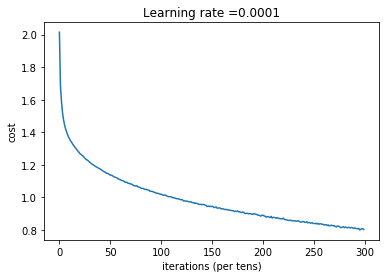

Parameters have been trained!
Train Accuracy: 0.72802
Test Accuracy: 0.4377


In [27]:
# parameters = model(X_train, Y_train, X_test, Y_test)

# 尝试卷积神经网络构建

卷积神经网络构造的时候需要用到原始的图像格式（即50000x32x32x3的矩阵），需要转换数据。

In [2]:
#数据集由Pickle模块存放，也以此解压
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
#加载所有数据
def loadDataSet():
    train_set_x_orig=[]
    train_set_y=[]
    #添加训练数据
    for i in range(1,6):
        fileName='data_batch_%s'%(str(i))
        rawDataDic=unpickle(fileName)
        train_set_x_orig.extend(list(rawDataDic[b'data']))
        train_set_y.extend(rawDataDic[b'labels'])
    train_set_x_orig=np.array(train_set_x_orig)
    train_set_y=np.array(train_set_y)
    #添加元数据
    rawMetadata=unpickle('batches.meta')
    classes=rawMetadata[b'label_names']
    for i in range(len(classes)):
        classes[i]=classes[i].decode()
    #添加测试数据
    rawTestDataDic=unpickle('test_batch')
    test_set_x_orig=rawTestDataDic[b'data']
    test_set_y=np.array(rawTestDataDic[b'labels'])
    #输出时需要对部分数据进行转置处理
    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes=loadDataSet()
X_train=train_set_x_orig.reshape(50000, 3, 32, 32)/255
X_dev=test_set_x_orig.reshape(10000, 3, 32, 32)[:5000,:]/255
X_test=test_set_x_orig.reshape(10000, 3, 32, 32)[5000:,:]/255
X_train=np.transpose(X_train, (0, 2, 3, 1))
X_dev=np.transpose(X_dev, (0, 2, 3, 1))
X_test=np.transpose(X_test, (0, 2, 3, 1))
#采用one-hot编码
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
Y_train = convert_to_one_hot(train_set_y, 10)
Y_dev = convert_to_one_hot(test_set_y, 10)[:5000,:]
Y_test = convert_to_one_hot(test_set_y, 10)[5000:,:]
print(Y_dev.shape)

(5000, 10)


计算卷积层的输出尺寸,卷积层输出的矩阵尺寸由三个因素决定：
- 输入矩阵尺寸
- 卷积核尺寸
- 步长
- 计算公式为
$$\mathrm{output = (input - kernel + 2 * padding) ~ / ~ stride + 1}$$

In [3]:
# 假设输入图片和卷积核的形状都是正方形
def get_output_shape(input_shape, kernel_shape, stride):
    j = kernel_shape - 1
    c = 0
    while j < input_shape:
        c += 1
        j += stride
    return c

# 假设图片尺寸为 32 x 32 x 3，卷积核尺寸为 3 x 3 x 3，步长为 2，卷积核个数 64
n_kernel = 64
input_shape = 32
output_shape = get_output_shape(32, 3, 2)
print('Input Shape = ', (input_shape, input_shape, 3))
print('Output Shape = ', (output_shape, output_shape, n_kernel))

Input Shape =  (32, 32, 3)
Output Shape =  (15, 15, 64)


**构造模型**

模型由以下几层组合而成
- 卷积层：用卷积核与每个图像进行卷积计算，输出特征图（Feature map），图像的深度得到扩展。
- 池化层：挑选取值最大的像素点作为代表，主要意义是降维（降低图像尺寸）
- 展开层：将三维的图像数据拉直为一维向量，向量的每个元素被视为一个特征，方便送入全连接层。
- 全连接层：特征的非线性分类器，与 MLP 中的全链接层功能一样。

**tf.layers.conv2d**

tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer=None, bias_initializer=?, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, trainable=True, name=None, reuse=None)

**tf.nn.conv2d**

tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)

conv2d 是一个 operation，要求输入的 input 和 filter 本身都是 Tensor 类型的对象，因此需要先用 tf.Variable 定义这两个对象，并且对权重矩阵这个 Tensor 进行初始化才能调用 conv2d 函数。

In [35]:
#创建卷积层
def conv_layer(x, out_channel, k_size, stride, padding):
    in_channel = x.shape[3].value
    #生成正态分布权重
    w = tf.Variable(tf.truncated_normal([k_size, k_size, in_channel, out_channel], mean=0, stddev=0.01))
    b = tf.Variable(tf.zeros(out_channel))
    x = tf.nn.conv2d(x, filter=w, strides=[1, stride, stride, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x

#创建池化层
def pool_layer(x, k_size, stride, padding):
    return tf.nn.max_pool(x, ksize=[1, k_size, k_size, 1], strides=[1, stride, stride, 1], padding=padding)

#将多维图像展开成矢量
def flatten_layer(x):
    dim = x.shape[1].value * x.shape[2].value * x.shape[3].value
    return tf.reshape(x, shape=[-1, dim])

#构建全连接层
def fc_layer(x, n_output):
    w = tf.Variable(tf.truncated_normal([x.shape[1].value, n_output], mean=0, stddev=0.01))
    b = tf.Variable(tf.zeros(n_output))
    x = tf.matmul(x, w)
    x = tf.add(x, b)
    x = tf.nn.relu(x)
    return x

#采用dropout训练策略
def dropout_layer(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

#构建输出层
def output_layer(x, n_output):
    w = tf.Variable(tf.truncated_normal([x.shape[1].value, n_output], mean=0, stddev=0.01))
    b = tf.Variable(tf.zeros(n_output))
    x = tf.matmul(x, w)
    x = tf.add(x, b)
    x = tf.identity(x, name='logits')  # Rename
    return x

In [36]:
#创建整体模型
def create_model(x, keep_prob):
    x = conv_layer(x, 16, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = conv_layer(x, 32, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = conv_layer(x, 64, 3, 1, 'SAME')
    x = pool_layer(x, 2, 2, 'VALID')
    x = flatten_layer(x)
    x = fc_layer(x, 128)
    x = dropout_layer(x, keep_prob)
    x = output_layer(x, 10)   
    return x

**训练模型**

In [3]:
#获取minibatch
def get_batch(x, y, batch_size):
    for start in range(0, len(x), batch_size):
        end = min(start + batch_size, len(x))
        yield x[start:end], y[start:end]
#构建随机minibatch数据集
def random_mini_batches(X, Y, mini_batch_size = 64):  
    m = X.shape[0]                  
    mini_batches = []   
    # 对训练数据随机洗牌打乱
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    # 分割数据集
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)    
    # 处理最后多余的数据
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)   
    return mini_batches

**开启tensorflow对话session进入训练**

In [5]:
def cnnModel(X_train, Y_train, X_dev, Y_dev,X_test,Y_test,epochs = 200, n_class=5,batch_size = 128, stddev=0.01,dropout=0.5,create_model=create_model2):
    #建立计算图
    tf.reset_default_graph()
    #创建占位器
    x_input   = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x_input')
    y_true    = tf.placeholder(tf.float32, shape=(None, n_class), name='y_true')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    #构建模型
    y_pred = create_model(x_input, keep_prob)
    #计算损失函数
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
    #采用adam策略进行后向传播
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #计算准确率
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    history = {}
    history['acc'] = []
    history['val_acc'] = []
    history['test_acc'] = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # 可视化整个网络结构的视图，通过 TensorBoard 查看
#         tf.summary.FileWriter('./graphs', session.graph)
        session.run(tf.global_variables_initializer())
        for i in range(epochs):
            # 将训练集按 batch_size 切分为很多 batch，每个 batch 用于更新一次模型参数
            minibatch=random_mini_batches(X_train, Y_train, batch_size)
            for (X_batch, Y_batch) in minibatch:
                session.run(optimizer, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:dropout})

            # 本轮训练集最后一个 batch 的损失值
            loss = session.run(cost, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
            
            # 本轮训练后的模型用于训练集的最后一个 batch 的准确率
            acc = session.run(accuracy, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
            history['acc'].append(acc)

            # 本轮训练后的模型用于验证集的准确率
            devbatch=random_mini_batches(X_dev, Y_dev, 256)
            accNum=0
            for (X_devbatch, Y_devbatch) in devbatch:
                temp_acc = session.run(accuracy, feed_dict={x_input:X_devbatch, y_true:Y_devbatch, keep_prob:1})
                accNum+=X_devbatch.shape[0]*temp_acc
            val_acc=accNum/float(X_dev.shape[0])
            history['val_acc'].append(val_acc)
            
            # 本轮训练后的模型用于测试集的准确率
            testbatch=random_mini_batches(X_test, Y_test, 256)
            accNum=0
            for (X_testbatch, Y_testbatch) in testbatch:
                temp_acc = session.run(accuracy, feed_dict={x_input:X_testbatch, y_true:Y_testbatch, keep_prob:1})
                accNum+=X_testbatch.shape[0]*temp_acc
            test_acc=accNum/float(X_test.shape[0])
            history['test_acc'].append(test_acc)
            
            if i%5==0:
                print("Epoch =", i, "    train_loss =", loss, 
                      "     train_acc =", round(acc * 100, 2), "%", 
                      "     validation_acc =", round(val_acc * 100, 2), "%",
                     "     test_acc =", round(test_acc * 100, 2), "%")
        saver = tf.train.Saver()
        save_path = saver.save(session, '.\michaelcifar5cnn2')
    plt.figure()
    plt.plot(range(150), history['acc'], label='Train Accuracy')
    plt.plot(range(150), history['val_acc'], label='Valid Accuracy')
    plt.title('Model , CIFAR-5 CNN Model', size=15)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch = 0     train_loss = 1.87186      train_acc = 26.25 %      validation_acc = 30.3 %
Epoch = 5     train_loss = 1.46563      train_acc = 43.75 %      validation_acc = 46.56 %
Epoch = 10     train_loss = 1.31803      train_acc = 52.5 %      validation_acc = 49.08 %
Epoch = 15     train_loss = 1.23911      train_acc = 61.25 %      validation_acc = 55.86 %
Epoch = 20     train_loss = 1.33666      train_acc = 47.5 %      validation_acc = 59.22 %
Epoch = 25     train_loss = 0.991741      train_acc = 66.25 %      validation_acc = 58.7 %
Epoch = 30     train_loss = 0.925526      train_acc = 67.5 %      validation_acc = 61.98 %
Epoch = 35     train_loss = 0.686648      train_acc = 80.0 %      validation_acc = 63.4 %
Epoch = 40     train_loss = 0.716769      train_acc = 78.75 %      validation_acc = 64.34 %
Epoch = 45     train_loss = 0.936018      train_acc = 70.0 %      validation_acc = 64.56 %
Epoch = 50     train_loss = 0.904111      train_acc = 57.5 %      validation_acc = 66.28 %
Epoc

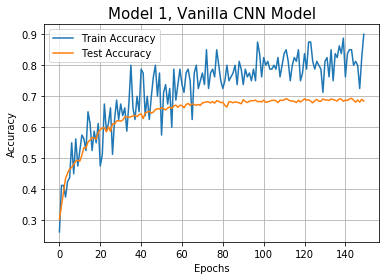

In [19]:
#cnnModel(X_train, Y_train, X_dev, Y_dev,epochs = 150)

下面这个模型采用了三层卷积三层池化，和上面不同的是这个模型采用了L2正则化和batch normalization。

In [4]:
def create_model2(x, keep_prob):
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 128, activation_fn=tf.nn.relu)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=None)
    return x

Epoch = 0     train_loss = 1.57026      train_acc = 40.0 %      validation_acc = 48.02 %
Epoch = 5     train_loss = 1.00883      train_acc = 61.25 %      validation_acc = 62.64 %
Epoch = 10     train_loss = 0.86923      train_acc = 67.5 %      validation_acc = 66.52 %
Epoch = 15     train_loss = 0.602133      train_acc = 76.25 %      validation_acc = 69.84 %
Epoch = 20     train_loss = 0.738258      train_acc = 73.75 %      validation_acc = 71.8 %
Epoch = 25     train_loss = 0.709689      train_acc = 78.75 %      validation_acc = 71.98 %
Epoch = 30     train_loss = 0.680071      train_acc = 75.0 %      validation_acc = 72.38 %
Epoch = 35     train_loss = 0.694076      train_acc = 80.0 %      validation_acc = 72.48 %
Epoch = 40     train_loss = 0.504386      train_acc = 81.25 %      validation_acc = 73.0 %
Epoch = 45     train_loss = 0.709781      train_acc = 75.0 %      validation_acc = 73.54 %
Epoch = 50     train_loss = 0.388656      train_acc = 86.25 %      validation_acc = 73.36 %


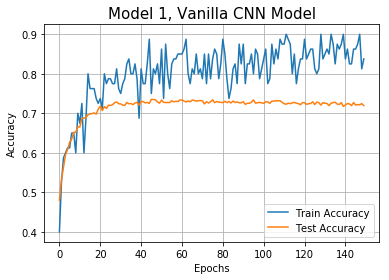

In [10]:
# cnnModel(X_train, Y_train, X_dev, Y_dev,epochs = 150,create_model=create_model2)

**采用类似于 VGG16 的结构创建模型。**
- 使用固定尺寸的小卷积核 3 x 3
- 两层卷积搭配一层池化
- 使用 VGG16 的前三个卷积池化结构：以2的幂次递增卷积核数量 (64, 128, 256)
- 模型的全连接层没有采用 VGG16 庞大的三层结构
- 卷积层输出直接上 10 分类的 Softmax Classifier
- 权重初始化全部采用 Xavier,并且采用batch normalization和L2正则化

In [8]:
def create_model3(x, keep_prob):
    #layer1
    x = tf.contrib.layers.conv2d(x, 64, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.contrib.layers.conv2d(x, 64, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    #layer2
    x = tf.contrib.layers.conv2d(x, 128, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.contrib.layers.conv2d(x, 128, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    #layer3
    x = tf.contrib.layers.conv2d(x, 256, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.contrib.layers.conv2d(x, 256, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    
    x = tf.contrib.layers.flatten(x)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=tf.nn.softmax)
    return x

In [ ]:
cnnModel(X_train, Y_train, X_dev, Y_dev,epochs = 150,create_model=create_model3)

类似采用Lenet-5框架模型。
![image.png](attachment:image.png)
- 第一层，卷积层
这一层的输入就是原始的图像像素32x32x1。第一个卷积层过滤器尺寸为5x5，深度为6，不使用全0填充，步长为1。

- 第二层，池化层
这一层的输入为第一层的输出，本层采用的过滤器大小为2x2，长和宽的步长均为2。

- 第三层，卷积层
本层使用的过滤器大小为5x5，深度为16.本层不使用全0填充，步长为1。

- 第四层，池化层
本层采用的过滤器大小为2x2，长和宽的步长均为2。

- 第五层，全连接层
本层全连接节点120。
- 第六层，全连接层
本层全连接节点84。
- 第七层，全连接层
本层全连接节点为输出标签类别10。

In [9]:
def create_Lenetmodel(x, keep_prob):
    #layer1-2(卷积+池化)
    x = tf.contrib.layers.conv2d(x, 6, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    #layer3-4(卷积+池化)
    x = tf.contrib.layers.conv2d(x, 16, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    #layer5（全连接）   
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 120, activation_fn=tf.nn.relu)
    x = tf.nn.dropout(x, keep_prob)
    #layer6(全连接)
    x = tf.contrib.layers.fully_connected(x, 84, activation_fn=tf.nn.relu)
    #layer7(全连接)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=tf.nn.softmax)
    return x

Epoch = 0     train_loss = 2.00615      train_acc = 45.0 %      validation_acc = 43.8 %
Epoch = 5     train_loss = 1.87058      train_acc = 58.75 %      validation_acc = 57.0 %
Epoch = 10     train_loss = 1.83081      train_acc = 63.75 %      validation_acc = 61.16 %
Epoch = 15     train_loss = 1.79451      train_acc = 67.5 %      validation_acc = 61.86 %
Epoch = 20     train_loss = 1.79619      train_acc = 67.5 %      validation_acc = 63.74 %
Epoch = 25     train_loss = 1.75748      train_acc = 71.25 %      validation_acc = 63.8 %
Epoch = 30     train_loss = 1.86352      train_acc = 60.0 %      validation_acc = 65.36 %
Epoch = 35     train_loss = 1.69729      train_acc = 76.25 %      validation_acc = 65.16 %
Epoch = 40     train_loss = 1.68267      train_acc = 77.5 %      validation_acc = 66.54 %
Epoch = 45     train_loss = 1.69059      train_acc = 77.5 %      validation_acc = 66.14 %
Epoch = 50     train_loss = 1.7546      train_acc = 70.0 %      validation_acc = 66.62 %
Epoch = 55  

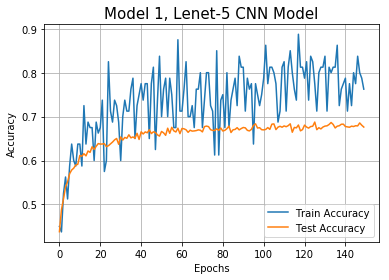

In [10]:
cnnModel(X_train, Y_train, X_dev, Y_dev,epochs = 150,create_model=create_Lenetmodel)

In [8]:
def create_Alexnetmodel(x, keep_prob):
    #layer1(卷积+lrn+池化)
    x = tf.contrib.layers.conv2d(x, 24, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
#     x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    x = tf.nn.dropout(x, keep_prob)
    #layer2(卷积+lrn+池化)
    x = tf.contrib.layers.conv2d(x, 96, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
#     x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    x = tf.nn.dropout(x, keep_prob)
    #layer3（卷积）
    x = tf.contrib.layers.conv2d(x, 192, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
#     x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)
    #layer4（卷积）
    x = tf.contrib.layers.conv2d(x, 192, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
#     x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)    
    #layer5（卷积）
    x = tf.contrib.layers.conv2d(x, 96, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
#     x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    #池化
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    x = tf.contrib.layers.flatten(x)
    #layer6(全连接)
    x = tf.contrib.layers.fully_connected(x, 1024, activation_fn=tf.nn.relu)
    x = tf.nn.dropout(x, keep_prob)
    #layer7(全连接)
    x = tf.contrib.layers.fully_connected(x, 1024, activation_fn=tf.nn.relu)
    #layer8(全连接)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=tf.nn.softmax)
    return x

Epoch = 0     train_loss = 2.07758      train_acc = 40.0 %      validation_acc = 39.4 %
Epoch = 5     train_loss = 1.9839      train_acc = 47.5 %      validation_acc = 48.7 %
Epoch = 10     train_loss = 1.79177      train_acc = 66.25 %      validation_acc = 57.44 %
Epoch = 15     train_loss = 1.87779      train_acc = 57.5 %      validation_acc = 56.84 %
Epoch = 20     train_loss = 1.95844      train_acc = 50.0 %      validation_acc = 45.24 %
Epoch = 25     train_loss = 2.38615      train_acc = 7.5 %      validation_acc = 10.28 %
Epoch = 30     train_loss = 2.39865      train_acc = 6.25 %      validation_acc = 10.24 %
Epoch = 35     train_loss = 2.36115      train_acc = 10.0 %      validation_acc = 10.24 %
Epoch = 40     train_loss = 2.34865      train_acc = 11.25 %      validation_acc = 10.24 %
Epoch = 45     train_loss = 2.32365      train_acc = 13.75 %      validation_acc = 10.24 %
Epoch = 50     train_loss = 2.28615      train_acc = 17.5 %      validation_acc = 10.24 %
Epoch = 55   

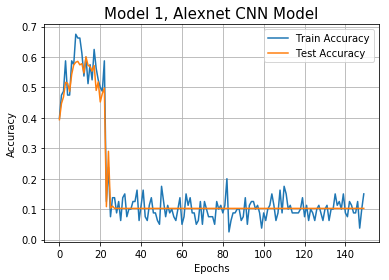

In [9]:
cnnModel(X_train, Y_train, X_dev, Y_dev,epochs = 150,create_model=create_Alexnetmodel,dropout=0.9)

In [6]:
#创建整体模型
def create_cnnmodel(x, keep_prob): 
    x = tf.contrib.layers.conv2d(x, 64, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
    x = tf.contrib.layers.conv2d(x, 64, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 384, activation_fn=tf.nn.relu,weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 192, activation_fn=tf.nn.relu,weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 10, activation_fn=None)
    return x

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch = 0     train_loss = 0.7748467      train_acc = 68.75 %      validation_acc = 60.7 %      test_acc = 59.58 %
Epoch = 5     train_loss = 0.7334186      train_acc = 81.25 %      validation_acc = 75.4 %      test_acc = 74.08 %
Epoch = 10     train_loss = 0.118371144      train_acc = 100.0 %      validation_acc = 77.06 %      test_acc = 76.98 %
Epoch = 15     train_loss = 0.16304652      train_acc = 93.75 %      validation_acc = 78.5 %      test_acc = 78.3 %
Epoch = 20     train_loss = 0.029322933      train_acc = 100.0 %      validation_acc = 78.72 %      test_acc = 78.78 %
Epoch = 25     train_loss = 0.0044349567      train_acc = 100.0 %      validation_acc = 78.56 %      test_acc = 78.02 %
Epoch = 30     train_loss = 0.050241586      train_acc = 100.0 %      validation_acc = 77.88 %      test

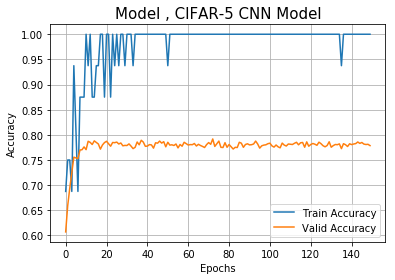

In [7]:
cnnModel(X_train, Y_train, X_dev, Y_dev,X_test,Y_test,batch_size = 64,n_class=10,epochs = 150,dropout=0.9,create_model=create_cnnmodel)

# 缩减数据集重新构建网络模型

考虑到数据量较大，种类较多，想要达到较高精度具有一定困难，我们对数据作简化处理，将类别缩减到5类，每类大约6000张图片，共30000张图片，其中20000张作训练集，5000张作验证集，5000张作测试集

In [2]:
#数据集由Pickle模块存放，也以此解压
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
#加载所有数据
def loadDataSet():
    train_set_x_orig=[]
    train_set_y=[]
    #添加训练数据
    for i in range(1,6):
        fileName='data_batch_%s'%(str(i))
        rawDataDic=unpickle(fileName)
        train_set_x_orig.extend(list(rawDataDic[b'data']))
        train_set_y.extend(rawDataDic[b'labels'])
    train_set_x_orig=np.array(train_set_x_orig)
    train_set_y=np.array(train_set_y)
    train_set_x_orig=train_set_x_orig[np.nonzero(train_set_y<5)[0],:]
    train_set_y=train_set_y[np.nonzero(train_set_y<5)[0]]
    #添加元数据
    rawMetadata=unpickle('batches.meta')
    classes=rawMetadata[b'label_names']
    for i in range(5):
        classes[i]=classes[i].decode()
    #添加测试数据
    rawTestDataDic=unpickle('test_batch')
    test_set_x_orig=np.array(rawTestDataDic[b'data'])
    test_set_y=np.array(rawTestDataDic[b'labels'])
    test_set_x_orig=test_set_x_orig[np.nonzero(test_set_y<5)[0],:]
    test_set_y=test_set_y[np.nonzero(test_set_y<5)[0]]
    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes=loadDataSet()
X_train=train_set_x_orig.reshape(25000, 3, 32, 32)[:20000,:]/255
X_dev=train_set_x_orig.reshape(25000, 3, 32, 32)[20000:,:]/255
X_test=test_set_x_orig.reshape(5000, 3, 32, 32)/255
X_train=np.transpose(X_train, (0, 2, 3, 1))
X_dev=np.transpose(X_dev, (0, 2, 3, 1))
X_test=np.transpose(X_test, (0, 2, 3, 1))
#采用one-hot编码
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
Y_train = convert_to_one_hot(train_set_y, 5)[:20000,:]
Y_dev = convert_to_one_hot(train_set_y, 5)[20000:,:]
Y_test = convert_to_one_hot(test_set_y, 5)
print(Y_train.shape)

(20000, 5)


In [3]:
#获取minibatch
def get_batch(x, y, batch_size):
    for start in range(0, len(x), batch_size):
        end = min(start + batch_size, len(x))
        yield x[start:end], y[start:end]
#构建随机minibatch数据集
def random_mini_batches(X, Y, mini_batch_size = 64):  
    m = X.shape[0]
    mini_batches = []   
    # 对训练数据随机洗牌打乱
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    # 分割数据集
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)    
    # 处理最后多余的数据
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)   
    return mini_batches

In [4]:
def create_model2(x, keep_prob):
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.conv2d(x, 16, 3, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.1))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 128, activation_fn=tf.nn.relu)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 5, activation_fn=None)
    return x

In [5]:
def cnnModel(X_train, Y_train, X_dev, Y_dev,X_test,Y_test,epochs = 200, n_class=5,batch_size = 128, stddev=0.01,dropout=0.5,create_model=create_model2):
    #建立计算图
    tf.reset_default_graph()
    #创建占位器
    x_input   = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x_input')
    y_true    = tf.placeholder(tf.float32, shape=(None, n_class), name='y_true')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    #构建模型
    y_pred = create_model(x_input, keep_prob)
    #计算损失函数
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
    #采用adam策略进行后向传播
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #计算准确率
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    history = {}
    history['acc'] = []
    history['val_acc'] = []
    history['test_acc'] = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # 可视化整个网络结构的视图，通过 TensorBoard 查看
#         tf.summary.FileWriter('./graphs', session.graph)
        session.run(tf.global_variables_initializer())
        for i in range(epochs):
            # 将训练集按 batch_size 切分为很多 batch，每个 batch 用于更新一次模型参数
            minibatch=random_mini_batches(X_train, Y_train, batch_size)
            for (X_batch, Y_batch) in minibatch:
                session.run(optimizer, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:dropout})

            # 本轮训练集最后一个 batch 的损失值
            loss = session.run(cost, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
            
            # 本轮训练后的模型用于训练集的最后一个 batch 的准确率
            acc = session.run(accuracy, feed_dict={x_input:X_batch, y_true:Y_batch, keep_prob:1})
            history['acc'].append(acc)

            # 本轮训练后的模型用于验证集的准确率
            devbatch=random_mini_batches(X_dev, Y_dev, 256)
            accNum=0
            for (X_devbatch, Y_devbatch) in devbatch:
                temp_acc = session.run(accuracy, feed_dict={x_input:X_devbatch, y_true:Y_devbatch, keep_prob:1})
                accNum+=X_devbatch.shape[0]*temp_acc
            val_acc=accNum/float(X_dev.shape[0])
            history['val_acc'].append(val_acc)
            
            # 本轮训练后的模型用于测试集的准确率
            testbatch=random_mini_batches(X_test, Y_test, 256)
            accNum=0
            for (X_testbatch, Y_testbatch) in testbatch:
                temp_acc = session.run(accuracy, feed_dict={x_input:X_testbatch, y_true:Y_testbatch, keep_prob:1})
                accNum+=X_testbatch.shape[0]*temp_acc
            test_acc=accNum/float(X_test.shape[0])
            history['test_acc'].append(test_acc)
            
            if i%5==0:
                print("Epoch =", i, "    train_loss =", loss, 
                      "     train_acc =", round(acc * 100, 2), "%", 
                      "     validation_acc =", round(val_acc * 100, 2), "%",
                     "     test_acc =", round(test_acc * 100, 2), "%")
        saver = tf.train.Saver()
        save_path = saver.save(session, '.\michaelcifar5cnn2')
    plt.figure()
    plt.plot(range(150), history['acc'], label='Train Accuracy')
    plt.plot(range(150), history['val_acc'], label='Valid Accuracy')
    plt.title('Model , CIFAR-5 CNN Model', size=15)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch = 0     train_loss = 1.02828      train_acc = 62.5 %      validation_acc = 62.76 %      test_acc = 61.62 %
Epoch = 5     train_loss = 0.563125      train_acc = 81.25 %      validation_acc = 73.18 %      test_acc = 72.98 %
Epoch = 10     train_loss = 0.441529      train_acc = 75.0 %      validation_acc = 76.42 %      test_acc = 75.88 %
Epoch = 15     train_loss = 0.424749      train_acc = 87.5 %      validation_acc = 77.48 %      test_acc = 77.26 %
Epoch = 20     train_loss = 0.22191      train_acc = 93.75 %      validation_acc = 78.54 %      test_acc = 77.72 %
Epoch = 25     train_loss = 0.292624      train_acc = 90.62 %      validation_acc = 79.4 %      test_acc = 78.3 %
Epoch = 30     train_loss = 0.33748      train_acc = 90.62 %      validation_acc = 78.0 %      test_acc = 77.34 %
Epoch = 35     train_loss = 0.299075      train_acc = 84.38 %      validation_acc = 79.56 %      test_acc = 78.6 %
Epoch = 40     train_loss = 0.290564      train_acc = 87.5 %      validation_acc = 7

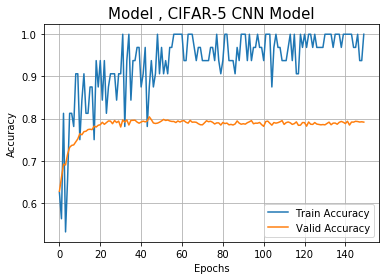

In [6]:
cnnModel(X_train, Y_train, X_dev, Y_dev,X_test,Y_test,epochs = 150,create_model=create_model2)

In [6]:
#创建整体模型
def create_cnnmodel(x, keep_prob): 
    x = tf.contrib.layers.conv2d(x, 64, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.0))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
    x = tf.contrib.layers.conv2d(x, 64, 5, 1, 'SAME', activation_fn=None, weights_regularizer=tf.contrib.layers.l2_regularizer(0.0))
    x = tf.contrib.layers.batch_norm(x)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
    x = tf.contrib.layers.flatten(x)
    x = tf.contrib.layers.fully_connected(x, 384, activation_fn=tf.nn.relu,weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 192, activation_fn=tf.nn.relu,weights_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    x = tf.nn.dropout(x, keep_prob)
    x = tf.contrib.layers.fully_connected(x, 5, activation_fn=None)
    return x

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch = 0     train_loss = 0.6959928      train_acc = 81.25 %      validation_acc = 65.8 %      test_acc = 65.6 %
Epoch = 5     train_loss = 0.36626      train_acc = 93.75 %      validation_acc = 80.18 %      test_acc = 79.54 %
Epoch = 10     train_loss = 0.18384442      train_acc = 93.75 %      validation_acc = 81.92 %      test_acc = 82.36 %
Epoch = 15     train_loss = 0.19754618      train_acc = 93.75 %      validation_acc = 82.34 %      test_acc = 81.42 %
Epoch = 20     train_loss = 0.036329698      train_acc = 100.0 %      validation_acc = 83.34 %      test_acc = 82.56 %
Epoch = 25     train_loss = 0.06259545      train_acc = 100.0 %      validation_acc = 84.52 %      test_acc = 83.14 %
Epoch = 3

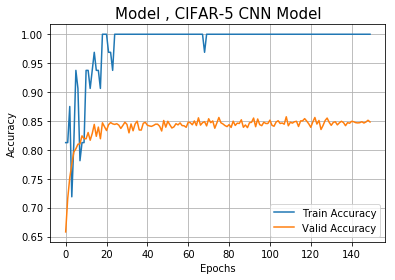

In [7]:
cnnModel(X_train, Y_train, X_dev, Y_dev,X_test,Y_test,batch_size = 64,epochs = 150,dropout=0.9,create_model=create_cnnmodel)